In [2]:
import numpy as np
import scipy as sc
from numba import jit, float64
import matplotlib.pyplot as plt

## Chambolle-Pock

Problem:
$$\textrm{minimize} \left\lVert x \right\rVert _1 \textrm{subject to } Ax=b$$
or
$$\textrm{minimize} \left\lVert x \right\rVert _1 + \delta_{b}(Ax)$$
Algorithm for a problem $\textrm{minimize} f(x) + g(Ax)$:
$$x_{n+1} = \mathrm{prox}_{\lambda f}(x_n - \lambda A^T\omega_n)$$
$$w_{n+1} = \mathrm{prox}_{\beta g^*}(\omega_n+\beta A(2x_{n+1}-x_n)) $$
where $g^*(x^*) = \langle x^*, b \rangle$

In [9]:
# prox_{\lambda f}
@jit
def prox_f(x, step):
    vec = np.abs(x) - step
    vec[vec<0] = 0
    return np.sign(x)*vec


#prox_{\sigma g*}
@jit
def prox_g(x, b, step):
    return x - step*b

In [13]:
def l1_chambolle_pock(A, b, lambd, beta, N, **kwargs):
    x = kwargs.get('x0', np.zeros(A.shape[1]))
    omega = kwargs.get('omega0', np.zeros(A.shape[0]))
    sol = chambolle_pock(A, b, lambd, beta, N, x, omega)
    return sol

@jit
def chambolle_pock(A, b, lambd, beta, N, x, omega):
    A_t = A.T
    x_next = prox_f(x-lambd*np.dot(A_t, omega), lambd)
    omega_next = prox_g(omega + beta*np.dot(A, 2*x_next - x), b, beta)
    n = 1
    while n < N:
        x = x_next
        omega = omega_next
        x_next = prox_f(x-lambd*np.dot(A_t, omega), lambd)
        omega_next = prox_g(omega + beta*np.dot(A, 2*x_next - x), b, beta)
        n += 1
        # print("m = {}  {}% done".format(len(b), round(n/N*100, 2)), end='\r', flush=True)
    return x_next

In [23]:
x_test = np.array([0, 2, 0, 0, 0, 0, 0, 0, 0, 0])
A_test = np.random.normal(size=(8, 10))
y_test = np.matmul(A_test, x_test)
xs_test = [l1_chambolle_pock(A_test, y_test, 0.05, 0.05, N) for N in [300, 400, 500, 600, 700, 800, 900, 1000]]

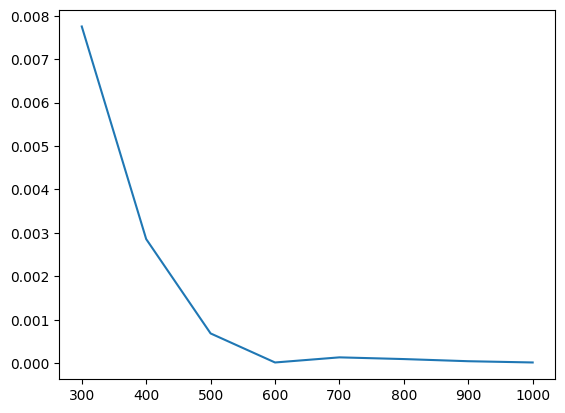

In [24]:
plt.plot([300, 400, 500, 600, 700, 800, 900, 1000], [np.linalg.norm(xx-x_test) for xx in xs_test])

In [25]:
A = np.random.normal(size=(10, 100))
np.linalg.norm(A, ord=2)**2

np.float64(154.2661103789284)

$2s \log{\frac{N}{s}} + \frac{5}{4}s + 1$ random Gaussian measurements suffice to recover the s-sparse vector

In [26]:
s = 10
N = 100
2*s*np.log(N/s) + 5/4*s + 1

np.float64(59.55170185988092)

In [27]:
x = np.zeros(100)
x[np.random.choice(range(0, 100), size=10, replace=False)] = np.random.randint(0, 2, 10)*2-1
ms = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
As = [[np.random.normal(size=(m, 100)) for m in ms] for i in range(10)]
ys = [[np.matmul(A, x) for A in A_sizes]for A_sizes in As]
x

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0., -1.,  0.,  0.,  1.,  0.,  0., -1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [28]:
solutions2 = [[l1_chambolle_pock(A, y, 0.01, 0.01, N=5000) for (A, y) in zip(A_sizes, y_sizes)] 
             for (A_sizes, y_sizes) in zip(As, ys)]

In [29]:
errors = np.array([[np.linalg.norm(sol - x) for sol in solutions_sizes] for solutions_sizes in solutions2])
success = np.zeros(errors.shape)
success[errors<0.001] = 1
success.sum(axis=0)

array([ 0.,  0.,  0.,  6.,  7., 10., 10., 10., 10., 10.])

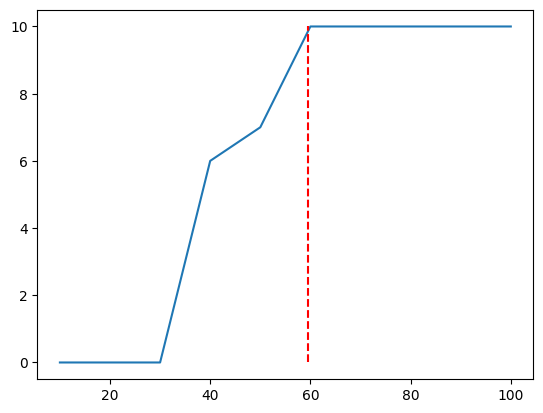

In [30]:
plt.plot(ms, success.sum(axis=0))
s = 10
N = 100
plt.vlines(2*s*np.log(N/s) + 5/4*s + 1, ymin=0, ymax=10, colors='red', linestyles='dashed')
plt.show()

plot matrix of successes with different s (imshow)
living on the edge paper

In [ ]:
'''
A: axis0 - varying m
   axis1 - different random matrices
x: axis0 - varying s
y: axis0 - varying s
   axis1 - varying m
   axis2 - different random matrices
'''

In [31]:
def phase_trans(dim, sparse_step, mesure_step, n_of_tests, n_iter=5000):

    x = np.zeros(shape=(dim//sparse_step+1, dim))
    for i in range(0, dim//sparse_step+1):
        non_sparse = np.random.choice(range(0, dim), size = i*sparse_step, replace=False)
        x[i, non_sparse] = np.random.randint(0, 2, size=non_sparse.shape[0])*2-1
    ms = np.linspace(mesure_step, dim, dim//mesure_step, dtype=int)
    As = [[np.random.normal(size=(m, dim)) for i in range(n_of_tests)] for m in ms]
    ys = [[[np.matmul(A, x_s) for A in As[i]] for i in range(len(ms))] for x_s in x]

    solutions = np.zeros((x.shape[0], len(ms), len(As[0]), dim))

    count = 0 
    for i in range(len(x)):
        for j in range(len(ms)):
            for k in range(n_of_tests):
                solutions[i][j][k] = l1_chambolle_pock(As[j][k], ys[i][j][k], 0.01, 0.01, N=n_iter)
                # print(f"s = {i*sparse_step:3d}, m = {(j+1)*mesure_step:3d}, test #{k:3d}/{n_of_tests}")
                count += 1
                if count%10==0: 
                    print("{:2f}% done".format(count/(len(x)*len(ms)*n_of_tests)*100), end='\r')

    return solutions, x
    

In [ ]:
res, x = phase_trans(100, 1, 1, 10, n_iter=10000)

In [65]:
error = np.zeros(res.shape[:-1])
for i in range(res.shape[0]):
    for j in range(res.shape[1]):
        for k in range(res.shape[2]):
            error[i, j, k] = np.linalg.norm(res[i, j, k] - x[i])
is_successful = np.zeros(res.shape[:-1])
is_successful[error<0.001] = 1
is_successful.sum(axis=2)

array([[10., 10., 10., ..., 10., 10., 10.],
       [ 0.,  2.,  0., ..., 10., 10., 10.],
       [ 0.,  0.,  0., ..., 10., 10., 10.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], shape=(101, 100))

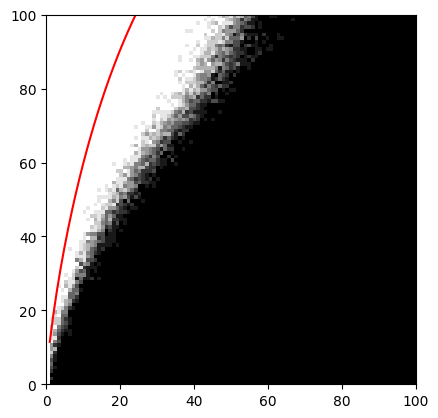

In [66]:
s = np.linspace(1, 100, 100)
crit = 2*s*np.log(100/s) + 5/4*s + 1
plt.plot(s, crit, c='red')
plt.imshow(is_successful.sum(axis=2).T, cmap='binary_r', extent=[0, 100, 0, 100], origin='lower')
plt.show()

In [34]:
import cvxpy as cp

In [33]:
def phase_trans_cvxpy(dim, sparse_step, mesure_step, n_of_tests):

    x = np.zeros(shape=(dim//sparse_step+1, dim))
    for i in range(0, dim//sparse_step+1):
        non_sparse = np.random.choice(range(0, dim), size = i*sparse_step, replace=False)
        x[i, non_sparse] = np.random.randint(-100, 100, size=non_sparse.shape[0])
    ms = np.linspace(mesure_step, dim, dim//mesure_step, dtype=int)
    As = [[np.random.normal(size=(m, dim)) for i in range(n_of_tests)] for m in ms]
    ys = [[[np.matmul(A, x_s) for A in As[i]] for i in range(len(ms))] for x_s in x]

    solutions = np.zeros((x.shape[0], len(ms), len(As[0]), dim))

    count = 0 
    for i in range(len(x)):
        for j in range(len(ms)):
            for k in range(n_of_tests):
                sol = cp.Variable(shape=x.shape[1])
                constr = [As[j][k]@sol == ys[i][j][k]]
                obj = cp.Minimize(cp.norm(sol, 1))
                prob = cp.Problem(obj, constr)
                prob.solve()
                solutions[i][j][k] = sol.value
                # print(f"s = {i*sparse_step:3d}, m = {(j+1)*mesure_step:3d}, test #{k:3d}/{n_of_tests}")
                count += 1
                if count%10==0: 
                    print("{:2f}% done".format(count/(len(x)*len(ms)*n_of_tests)*100), end='\r')

    return solutions, x

In [ ]:
res_cvxpy, x_cvxpy = phase_trans_cvxpy(100, 1, 1, 10)

In [10]:
error_cvxpy = np.zeros(res_cvxpy.shape[:-1])
for i in range(res_cvxpy.shape[0]):
    for j in range(res_cvxpy.shape[1]):
        for k in range(res_cvxpy.shape[2]):
            error_cvxpy[i, j, k] = np.linalg.norm(res_cvxpy[i, j, k] - x_cvxpy[i])
is_successful = np.zeros(res_cvxpy.shape[:-1])
is_successful[error_cvxpy<0.0001] = 1
is_successful.sum(axis=2)

array([[10., 10., 10., ..., 10., 10., 10.],
       [ 0.,  0.,  1., ..., 10., 10., 10.],
       [ 0.,  0.,  0., ..., 10., 10., 10.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  1., 10.],
       [ 0.,  0.,  0., ...,  0.,  0., 10.],
       [ 0.,  0.,  0., ...,  0.,  0., 10.]], shape=(101, 100))

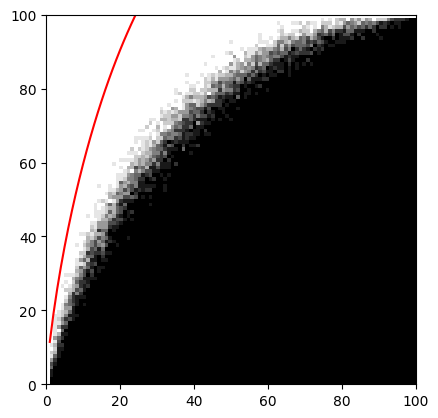

In [11]:
s = np.linspace(1, 100, 100)
crit = 2*s*np.log(100/s) + 5/4*s + 1
plt.plot(s, crit, c='red')
plt.imshow(is_successful.sum(axis=2).T, cmap='binary_r', extent=[0, 100, 0, 100], origin='lower')
plt.show()

в якості критерію зупинки можна використовувати відносну зміну приросту норми розв'язку на ітераціях